In [6]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

In [8]:
import os
for k, v in os.environ.items():
    if "HOPS" in k:
        print(f'{k}={v}')

In [9]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Multiple projects found. 

	 (1) gtheod99
	 (2) Scalable_ML_lab1

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/193684
Connected. Call `.close()` to terminate connection gracefully.


In [18]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from wine dataset",
                                  labels=["quality"],
                                  query=query)
print(feature_view)

In [39]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2, read_options={"use_hive": True})


Finished: Reading data from Hopsworks, using Hive (2.03s) 


In [40]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()
# X_train=sc.fit_transform(X_train)
# X_test=sc.fit_transform(X_test)

# Train our model with the Scikit-learn Linear Regression algorithm using our features (X_train) and labels (y_train)
#model = SVC()
model =  RandomForestClassifier()
model.fit(X_train, y_train.to_numpy().ravel())

RandomForestClassifier()

In [41]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)


print('Training Accuracy:',model.score(X_train, y_train))
print('Testing Accuracy:',model.score(X_test, y_test))
# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
results = confusion_matrix(y_test, y_pred)


Training Accuracy: 1.0
Testing Accuracy: 0.5992647058823529


In [42]:
results.shape

(6, 6)

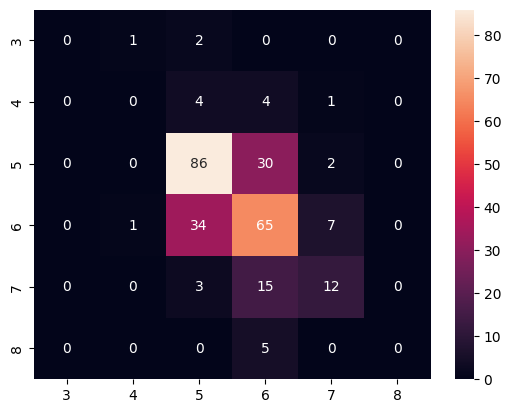

In [43]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file with clear labels
df_cm = pd.DataFrame(results, range(3, 9), range(3, 9))
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [44]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")
  

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 5422169/5422169 elapsed<00:04 remaining<00:002.91it/s]
Uploading: 100.000%|██████████| 18458/18458 elapsed<00:01 remaining<00:001,  2.91it/s]
Uploading: 100.000%|██████████| 1001/1001 elapsed<00:01 remaining<00:000:15,  3.98s/it]
Model export complete: 100%|██████████| 6/6 [00:14<00:00,  2.36s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/193684/models/wine_model/5


Model(name: 'wine_model', version: 5)